# Plot a Network Graph from DataFrame

These functions let you convert a pandas DataFrame
into a [networkx](https://networkx.org/) graph or plot 
directly as a graph using [Bokeh]
interactive plotting.

You give the functions the column names for the **source**
and **target** nodes to build a basic graph,
You can also name other columns to be node or edge
attributes. When displayed these attributes are
visible as popup details courtesy of Bokeh's Hover tool.

You can also opt to use different networkx layouts other than
the default `spring` layout.

Note: We use the term "network graph" in this document. 
This is shortened to "graph" when used in the context of Networkx 
e.g. "a Networkx graph".

In [19]:
import msticpy as mp
mp.init_notebook();

proc_df = pd.read_csv("./data/processes_on_host.csv", index_col=0)
proc_df["Process"] = proc_df.NewProcessName.str.extract(r".*\\([^\\]+)")
proc_df.head(3)

,TenantId,Account,EventID,TimeGenerated,Computer,SubjectUserSid,SubjectUserName,SubjectDomainName,SubjectLogonId,NewProcessId,NewProcessName,TokenElevationType,ProcessId,CommandLine,ParentProcessName,TargetLogonId,SourceComputerId,TimeCreatedUtc,Process
0,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 05:24:24.010,MSTICAlertsWin1,S-1-5-18,MSTICAlertsWin1$,WORKGROUP,0x3e7,0x1610,C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\CT_602681692\NativeDSC\De...,%%1936,0x888,"""C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\CT_602681692\NativeDSC\D...",C:\Program Files\Microsoft Monitoring Agent\Agent\MonitoringHost.exe,0x0,46fe7078-61bb-4bed-9430-7ac01d91c273,2019-01-15 05:24:24.010,ASMHost.exe
1,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 05:24:24.023,MSTICAlertsWin1,S-1-5-18,MSTICAlertsWin1$,WORKGROUP,0x3e7,0x1790,C:\Windows\System32\conhost.exe,%%1936,0x1610,\??\C:\Windows\system32\conhost.exe 0xffffffff -ForceV1,C:\Program Files\Microsoft Monitoring Agent\Agent\Health Service State\CT_602681692\NativeDSC\De...,0x0,46fe7078-61bb-4bed-9430-7ac01d91c273,2019-01-15 05:24:24.023,conhost.exe
2,802d39e1-9d70-404d-832c-2de5e2478eda,WORKGROUP\MSTICAlertsWin1$,4688,2019-01-15 05:24:25.807,MSTICAlertsWin1,S-1-5-18,MSTICAlertsWin1$,WORKGROUP,0x3e7,0xcd8,C:\Windows\SysWOW64\wbem\WmiPrvSE.exe,%%1936,0x280,C:\Windows\sysWOW64\wbem\wmiprvse.exe -secured -Embedding,C:\Windows\System32\svchost.exe,0x3e4,46fe7078-61bb-4bed-9430-7ac01d91c273,2019-01-15 05:24:25.807,WmiPrvSE.exe


## Overview

You can create and display a DataFrame as a network graph using
the MSTICPy pandas accesssor `mp_plot.network`.

This is an example featuring process creation events
using the SubjecUserName and Process name as nodes.
Node and edge attributes are taken from other DataFrame columns.

Note: use the WheelZoom tool to use the mouse scroll wheel
to zoom in and out of the plot.

In [34]:
proc_df.head(100).mp_plot.network(
    source_col="SubjectUserName",
    target_col="Process",
    source_attrs=["SubjectDomainName", "SubjectLogonId"],
    target_attrs=["NewProcessName", "ParentProcessName", "CommandLine"],
    edge_attrs=["TimeGenerated"],
)

Loading BokehJS ...

Figure(id='5002', ...)

## Creating a NetworkX Graph from a DataFrame

The `mp.to_graph` accessor will generate a NetworkX graph
from the input data. This is a method that is added
to DataFrames by MSTICPy.

You can supply the following parameters:

- source_col - Column for source nodes.
- target_col - Column for target nodes.
- source_attrs - Optional list of columns to use as source node attributes, by default None
- target_attrs - Optional list of columns to use as target node attributes, by default None
- edge_attrs - Optional list of columns to use as edge node attributes, by default None
- graph_type - "graph" or "digraph" (for nx.DiGraph)

It returns a NetworkX graph that you can perform graph
analyses on such as extracting subgraphs, analyzing connectedness, etc
See the [NetworkX documentation](https://networkx.org/documentation/stable/reference/index.html) for more details.

You can also import and use the underlying function.
This has the same functionality as the pandas accessor method.
```python3
from msticpy.transform.network.df_to_networkx

nx_graph = df_to_networkx(
    data=proc_df,
    source_col="SubjectUserName",
    target_col="Process"
)

In [20]:
nx_graph = proc_df.mp.to_graph(
    source_col="SubjectUserName",
    target_col="Process"
)

In [21]:
print("# nodes:", len(nx_graph.nodes()))
print("# edges:", len(nx_graph.edges()))

# nodes: 65
# edges: 67


Display the node with default attributes

In [14]:
nx_graph.nodes["MSTICAdmin"]

{'node_role': 'source', 'node_type': 'SubjectUserName'}

In [38]:
import networkx as nx
# Show neighbors of a node - which processes where executed by this account
list(nx.neighbors(nx_graph, "MSTICAdmin"))[:15]

['reg.exe',
 'cmd.exe',
 'rundll32.exe',
 '42424.exe',
 '1234.exe',
 'tsetup.1.exe',
 'netsh.exe',
 'perfc.dat',
 'sdopfjiowtbkjfnbeioruj.exe',
 'doubleextension.pdf.exe',
 'vssadmin.exe',
 'conhost.exe',
 'net.exe',
 'net1.exe',
 'regsvr32.exe']

Adding node and edge attributes

In [39]:
nx_graph = proc_df.mp.to_graph(
    source_col="SubjectUserName",
    target_col="Process",
    source_attrs=["SubjectDomainName", "SubjectLogonId"],
    target_attrs=["NewProcessName", "ParentProcessName", "CommandLine"],
    edge_attrs=["TimeGenerated"],
)

Display the node with added attributes

In [40]:
nx_graph.nodes["MSTICAdmin"]

{'SubjectDomainName': 'MSTICAlertsWin1',
 'SubjectLogonId': '0xfaac27',
 'node_role': 'source',
 'node_type': 'SubjectUserName'}

### Built-in Networkx Plotting

You can use the matplotlib built-in networkx plotting backend.
You can also use NetworkX functions to export the
graph to a variety of more flexibly visualization tools such as
GraphViz.


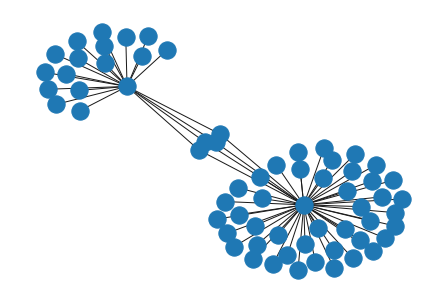

In [43]:
nx.draw(nx_graph)

## Plotting a Network

Using Bokeh plotting gives you interactivity as well as a more
informative display.

You can build and plot a graph in a single operation
using the `mp_plot.network` accessor method.

You can use the standard Bokeh tools to select nodes and
edges, to zoom and pan around the network graph and to hover over
elements to reveal attribute values.

Note: Bokeh graph plotting does not support interactive
dragging of nodes and recalculation of the layout.


In [31]:
proc_df.head(70).mp_plot.network(
    source_col="ParentProcessName",
    target_col="Process"
)

Loading BokehJS ...

Figure(id='4089', ...)

This has the same options as the `np.to_graph`
accessor method:

- source_col - Column for source nodes.
- target_col - Column for target nodes.
- source_attrs - Optional list of columns to use as source node attributes, by default None
- target_attrs - Optional list of columns to use as target node attributes, by default None
- edge_attrs - Optional list of columns to use as edge node attributes, by default None
- graph_type - "graph" or "digraph" (for nx.DiGraph)

In this case, they also cause the node and edge attributes
to be displayed on the plot using the Bokeh HoverTool. Moving
the mouse cursor over a node or edge will display the attributes.

Note the attributes for source and target nodes are both
shown with the HoverTool but only the values of populated attributes
for that node type (source or target) are shown.

In [41]:
proc_df.head(70).mp_plot.network(
    source_col="ParentProcessName",
    target_col="Process",
    source_attrs=["SubjectDomainName", "SubjectLogonId"],
    target_attrs=["NewProcessName", "ParentProcessName", "CommandLine"],
    edge_attrs=["TimeGenerated"],
)

Loading BokehJS ...

Figure(id='5500', ...)

There are a number of other parameters to control
the display of the graph.

- title - Title for the plot, by default 'Data Graph'
- node_size - Size of the nodes in pixels, by default 25
- font_size - Font size for node labels, by default 10. Can be an integer (point size) or a string (e.g. "10pt")
- width - Plot width in pixels, by default 800
- height - Plot height (the default is 800)
- plot scale - Position scale (the default is 2)
- hide - Don't show the plot, by default False. If True, just return the figure.
- source_color - The color of the source nodes, by default 'light-blue'
- target_color - The color of the source nodes, by default 'light-green'
- edge_color - The color of the edges, by default 'black'
- node_size - Size of the nodes in pixels, by default 25
- font_size - Font size for node labels, by default 10. Can be an integer (point size) or a string (e.g. "10pt")
- **kwargs - other keyword arguments will be passed to the Networkx layout function.

References
----------

- [Networkx from_pandas_edgelist](https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html)
- [Bokeh graph visualization](https://docs.bokeh.org/en/latest/docs/user_guide/graph.html)